Import and define utility functions like gaussian blurring and grayscale conversion

In [ ]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from numpy.testing import assert_array_equal

N_IMAGES = 9
# weights = [0.2989, 0.5870, 0.1140]  # r,g,b weights

def to_grayscale(img):
  result = 0.299 * img[:,:,0] + 0.587 * img[:,:,1] + 0.114 * img[:,:,2]
  return result.astype(np.uint8)

def gaussian_kernel(size, sigma=1):
    """Generate a 2D Gaussian kernel."""
    kernel = np.fromfunction(
        lambda x, y: (1/ (2 * np.pi * (sigma**2))) *
                     np.exp(-((x-(size-1)/2)**2 + (y-(size-1)/2)**2)/(2*sigma**2)),
        (size, size)
    )
    return kernel / np.sum(kernel)

def pad_image(image, pad_height, pad_width):
    """Pad the image with symmetric border."""
    return np.pad(image, ((pad_height, pad_height), (pad_width, pad_width)), mode='symmetric')

def convolve2d(image, kernel):
    """Perform 2D convolution of the image with the given kernel."""
    kernel_height, kernel_width = kernel.shape
    pad_height = kernel_height // 2
    pad_width = kernel_width // 2

    # Pad the input image
    padded_image = pad_image(image, pad_height, pad_width)

    try:
      assert len(image.shape) == 2  # assert that the image if gray
    except AssertionError:
      print("Incompatible dimensions, provide a grayscale image")
      exit(0)

    height, width = image.shape
    channels = 1

    output = np.zeros_like(image, dtype= np.float64)

    for i in range(height):
        for j in range(width):
            region = padded_image[i:i+kernel_height, j:j+kernel_width]
            output[i, j] = np.sum(region * kernel)

    return output

def gaussian_blur(image, kernel_size, sigma=1):
    kernel = gaussian_kernel(kernel_size)
    return convolve2d(image, kernel).astype(np.uint8)


Canny Edge Detector Implementation

In [ ]:
import numpy as np

def compute_gradients(image):
    sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=np.float64)
    sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=np.float64)

    gradient_x = convolve2d(image, sobel_x)
    gradient_y = convolve2d(image, sobel_y)

    gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
    gradient_direction = np.arctan2(gradient_y, gradient_x)

    return gradient_magnitude, gradient_direction

def non_max_suppression(gradient_magnitude, gradient_direction):
    height, width = gradient_magnitude.shape
    output = np.zeros_like(gradient_magnitude)

    angle = gradient_direction * 180 / np.pi
    angle[angle < 0] += 180

    for i in range(1, height-1):
        for j in range(1, width-1):
            q = 255
            r = 255

            if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                q = gradient_magnitude[i, j+1]
                r = gradient_magnitude[i, j-1]
            elif (22.5 <= angle[i,j] < 67.5):
                q = gradient_magnitude[i+1, j-1]
                r = gradient_magnitude[i-1, j+1]
            elif (67.5 <= angle[i,j] < 112.5):
                q = gradient_magnitude[i+1, j]
                r = gradient_magnitude[i-1, j]
            elif (112.5 <= angle[i,j] < 157.5):
                q = gradient_magnitude[i-1, j-1]
                r = gradient_magnitude[i+1, j+1]

            if (gradient_magnitude[i,j] >= q) and (gradient_magnitude[i,j] >= r):
                output[i,j] = gradient_magnitude[i,j]
            else:
                output[i,j] = 0

    return output

def double_threshold(image, low, high):
    high_threshold = high
    low_threshold = low

    strong_edges = (image >= high_threshold)
    weak_edges = (image >= low_threshold) & (image < high_threshold)

    return strong_edges, weak_edges

def hysteresis(strong_edges, weak_edges):
    # Here we update weak_edges as they are promoted so that they’re not reprocessed.
    h, w = strong_edges.shape
    output = np.copy(strong_edges)

    # Direction vectors for 8-connected neighborhood
    for i in range(1, h-1):
        for j in range(1, w-1):
            if weak_edges[i, j] == 1:
                # Check 8-connected neighbors
                if (output[i-1, j-1] == 1 or output[i-1, j] == 1 or output[i-1, j+1] == 1 or
                    output[i, j-1]   == 1 or                        output[i, j+1]   == 1 or
                    output[i+1, j-1] == 1 or output[i+1, j] == 1 or output[i+1, j+1] == 1):
                    output[i, j] = 1
                    # Update weak_edges to avoid re-checking this pixel in later iterations.
                    weak_edges[i, j] = 0
    # Since converting some weak edges might enable other weak edges to connect to a strong edge, iterate until no change.
    changed = True
    while changed:
        changed = False
        for i in range(1, h-1):
            for j in range(1, w-1):
                if weak_edges[i, j] == 1:
                    if (output[i-1, j-1] == 1 or output[i-1, j] == 1 or output[i-1, j+1] == 1 or
                        output[i, j-1]   == 1 or                        output[i, j+1]   == 1 or
                        output[i+1, j-1] == 1 or output[i+1, j] == 1 or output[i+1, j+1] == 1):
                        output[i, j] = 1
                        weak_edges[i, j] = 0
                        changed = True
    return output

def canny_detector(blurred, low, high, sigma=1, kernel_size=5):
    blurred = blurred.astype(np.float64)
    # Compute gradients
    gradient_magnitude, gradient_direction = compute_gradients(blurred)

    # Apply non-maximum suppression
    suppressed = non_max_suppression(gradient_magnitude, gradient_direction)

    # Double threshold
    strong_edges, weak_edges = double_threshold(suppressed, low, high)

    # Apply hysteresis
    edges = hysteresis(strong_edges, weak_edges)

    return edges * 255



In [ ]:
def mydilate(img,kernel):
  k_height, k_width = kernel.shape
  pad_height = k_height // 2
  pad_width = k_width // 2
  padded_image = np.pad(img, ((pad_height, pad_height), (pad_width, pad_width)),
                          mode='constant', constant_values=0)
  img_copy = np.zeros_like(img)
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      region = padded_image[i:i + k_height, j:j + k_width]
      img_copy[i, j] = np.max(region[kernel == 1])
  return img_copy

In [ ]:
def myerode(img,kernel):
  k_height, k_width = kernel.shape
  pad_height = k_height // 2
  pad_width = k_width // 2
  padded_image = np.pad(img, ((pad_height, pad_height), (pad_width, pad_width)),
                          mode='constant', constant_values=0)
  img_copy = np.zeros_like(img)
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      region = padded_image[i:i + k_height, j:j + k_width]
      img_copy[i, j] = np.min(region[kernel == 1])
  return img_copy

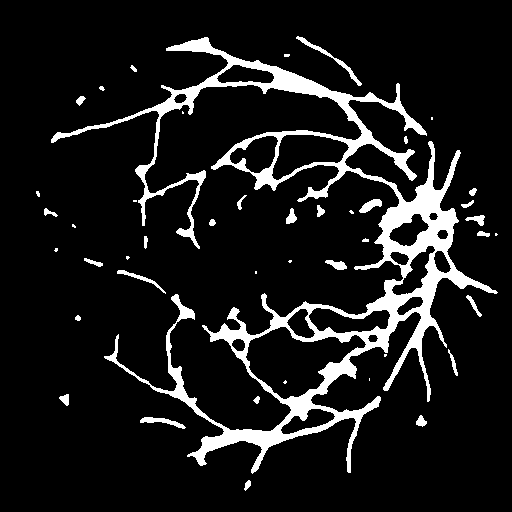

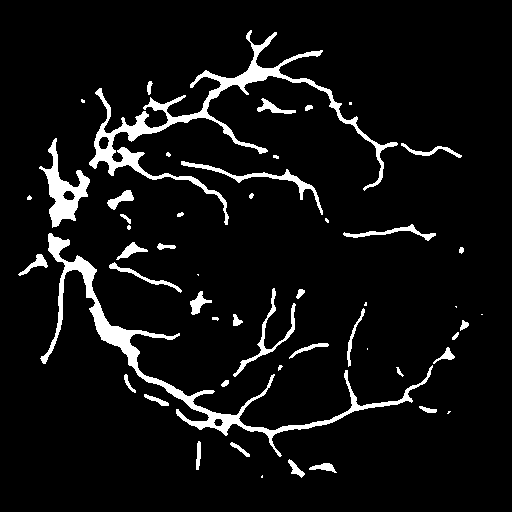

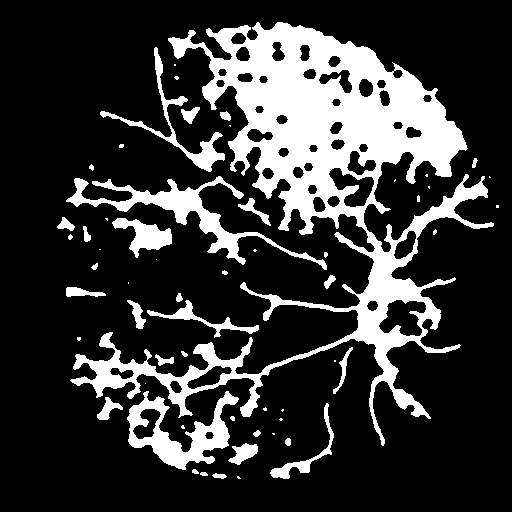

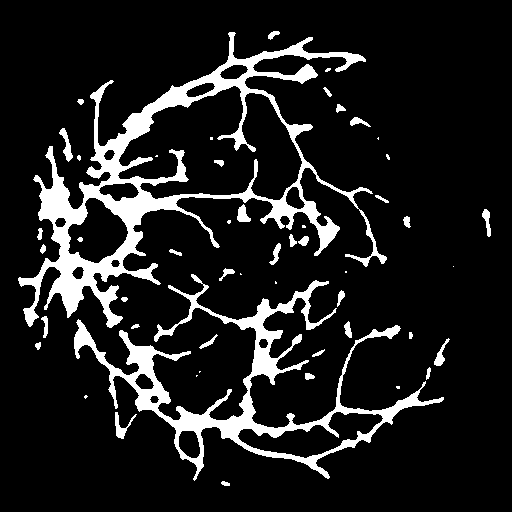

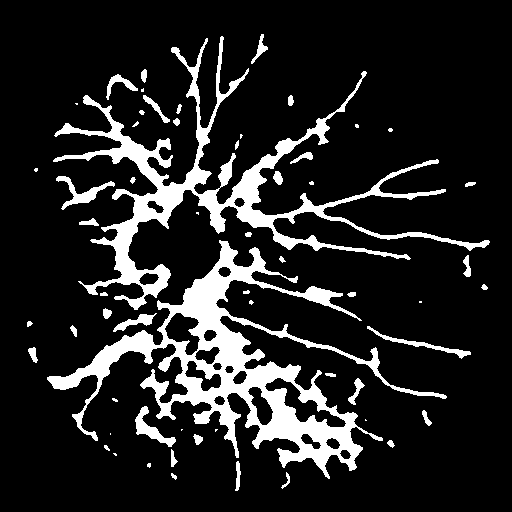

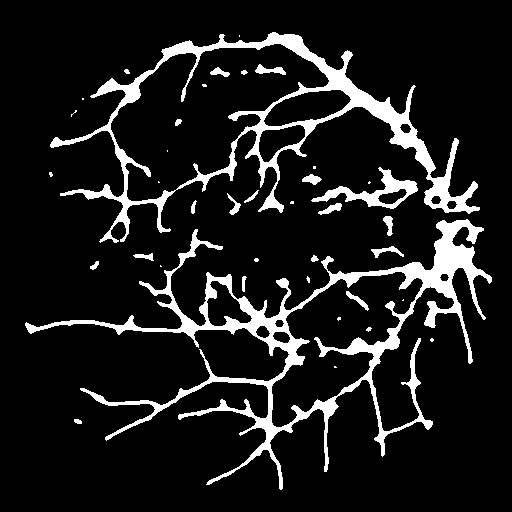

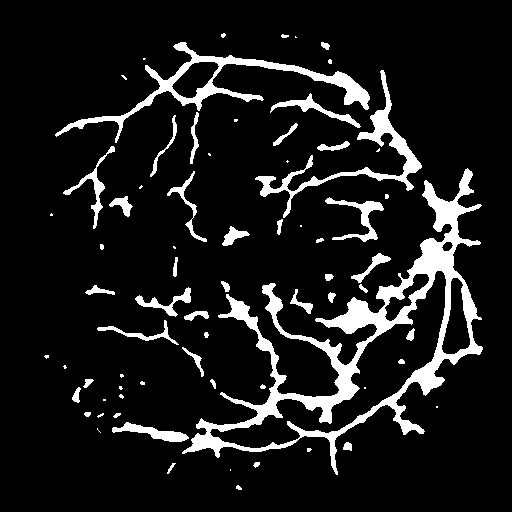

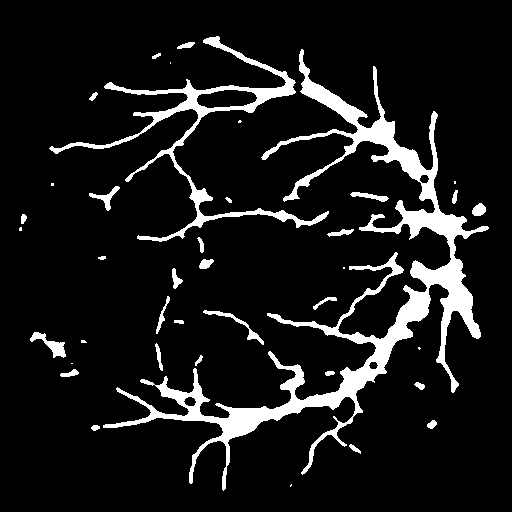

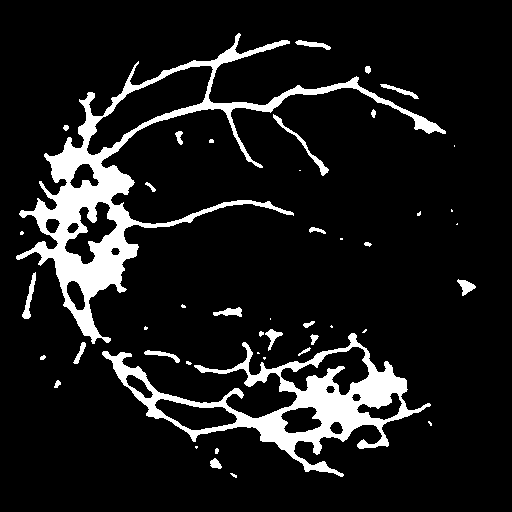

In [ ]:
for i in range(0, N_IMAGES):
  img = cv2.imread(f"image/{i}.png")
  grayscale_img = to_grayscale(img) # convert to grayscale
  blurred = gaussian_blur(grayscale_img, 3) # apply gaussian blur
  _, blurred = cv2.threshold(blurred, 150, 255, cv2.THRESH_TOZERO_INV)
  # cv2_imshow(blurred)
  # im1 = cv2.Canny(blurred, 15, 50) - cv2.Canny(blurred, 100, 200)
  im1 = canny_detector(blurred, 5, 20, sigma=1.4).astype(np.uint8)
  im2 = canny_detector(blurred, 50, 100, sigma=1.4).astype(np.uint8)
  # cv2_imshow(im1)

  im1 -= im2; # remove the boundary circle

  #cv2.morphologyEx(im1, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3)))
  kernel_d = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
  kernel_e = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
  kd=[[1,1,1],[1,1,1],[1,1,1]]
  ke=[[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1]]
  _, final = cv2.threshold(im1, 127, 255, cv2.THRESH_BINARY)
  for iii in range(0,4):
    final = mydilate(final, kernel_d)
  #cv2_imshow(final)
  final = myerode(final, kernel_e)
  final = myerode(final, kernel_d)
  final = myerode(final, kernel_d)
  x, y = final.shape
  for ii in range(10):
    for jj in range(y):
      final[ii, jj] = 0

  for ii in range(10):
    for jj in range(y):
      final[x - ii - 1, jj] = 0

  # convert to binary
  final = cv2.medianBlur(final, ksize=5)
  cv2_imshow(final)

  cv2.imwrite(f'output/{i}.png', final)

In [ ]:
import matplotlib.pyplot as plt

all_masks = []

# Read all predicted masks
for i in range(N_IMAGES):
        mask = cv2.imread('output/' + str(i) + '.png')
        all_masks.append(mask)

# Encoding
def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), non 0 - mask, 0 - background
    Returns run length as list
    '''
    run_lengths = []
    for i in range(x.shape[0]*x.shape[1]):
        run_lengths.append([])
    current = 0
    count = 0
    start = 0
    flat = x.T.flatten()
    for i in range(len(flat)):
        dot = flat[i]
        if dot == 0:
            if current == 0:
                continue
            else:
                run_lengths[current-1].extend([start, count])
                current = 0
                count = 0
                start = 0
        else:
            if dot == current:
                count += 1
            elif count != 0:
                run_lengths[current-1].extend([start, count])
                current = 0
                count = 0
                start = 0
            else:
                start = i
                current = dot
                count += 1
    return run_lengths



# Write submission
import csv

# File name
filename = "submission.csv"

# Writing to CSV file
with open(filename, mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["id", "encoding"])  # Header
        for file_id in range(9):
            enc = rle_encoding(all_masks[file_id])
            writer.writerow([file_id, enc])  # Data row

print(f"{filename} has been created successfully.")

submission.csv has been created successfully.
